---

# The basis for almost all quant finance theory: the Geometric Brownian Motion.<br>
--- 


by Marco Corradini

---

<p style="line-height:2.0">

### **Introduction**

In modern financial markets, **randomness** is a fundamental characteristic that makes forecasting asset returns exceptionally challenging. <br>
Every day, a myriad of unpredictable factors influence market movements, which means that attempting to predict precise future values often leads to unreliable results. <br>
This inherent uncertainty is why deterministic approaches frequently fall short when dealing with financial assets. <br><br>

As a consequence, mathematical models that incorporate a probabilistic foundation have proven to be the most effective in describing market behavior. <br> 
By acknowledging the randomness in markets, these models capture both the central tendency and the variability of asset returns, enabling a more realistic representation of risk and opportunity.

By treating financial returns as random variables, we now turn our attention to one of the cornerstones of quantitative finance: **Geometric Brownian Motion (GBM)**. <br>
GBM is widely accepted as a model for equities, currencies, commodities, and indices and it lays the foundation for the Black-Scholes model. <br>
Its formulation, captures both the deterministic trend (via the **drift** $\mu$) and the random fluctuations (via the **volatility** $\sigma$ and the Brownian motion **increment** $dX$). <br><br>

In this notebook, we derive the Geometric Brownian Motion by starting from a simple discete model for the random walk of assets.

<br>

---

### **Returns as random variables**

In quantitative finance, asset returns are modeled as random variables with a certain mean (first moment) and variance (second moment). <br>

Why don't we model asset prices directly? <br>
Prices often exhibit non-stationary behavior: their statistical properties (mean and variance) can change over time, making comparisons with the past and cross-assets hard. <br>
More practicaly, when you purchase an asset your main concern is that you will make a comfortable return on your investment. <br>
By return we tend to mean the percentage growth in the value of an asset, together with accumulated cashflows, over some periods:<br><br>
$ \text{Return}=\dfrac{\text{Change in value of the asset} + \text{accumualted cashflows}}{\text{Original value of the asset}}$

#### **Example: S&P 500** <br>

Let's download the historical daily price series of prices for the S&P 500 Total Return (SPXT), starting from September 1989 and ending in April 2025. <br>
Denoting the S&P 500 price on the $i^{th}$ day by $S_{i}$, then the return from day $i$ to day $i+1$ is given by:<br><br>
$R_{i+1}=\dfrac{S_{i+1}-S_{i}}{S_{i}}$ <br>
By using a total return index we have made the computation of returns much simpler, given that we don't have cashflows (dividends are reinvested in the index). <br>

Let's take a look at the SPXT returns over time:

</p>

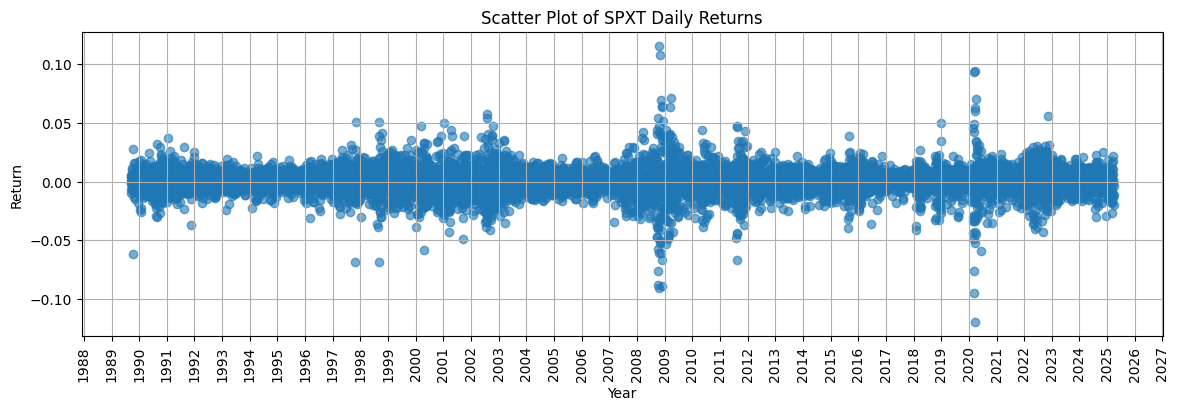

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# import data and parse 'Date' as datetime
df_spx = pd.read_csv('./data/spx_daily.csv', parse_dates=['Date'])

# compute returns
df_spx['Return'] = df_spx['Price'].pct_change()

# drop NaN values caused by pct_change
df_spx = df_spx.dropna(subset=['Return'])

# plot returns with time on X-axis (yearly ticks)
plt.figure(figsize=(12, 4))
plt.scatter(df_spx['Date'], df_spx['Return'], alpha=0.6)

# Format X-axis by year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('Scatter Plot of SPXT Daily Returns')
plt.xlabel('Year')
plt.ylabel('Return')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

The daily return seems a lot "noisy", and that's exactly how we are going to model it: $R_{i}$ is going to be a random variable with a certain distribution, mean and variance. <br>

From the data (the sample), we are able to compute the sample mean and the sample variance of $R_{i}$:<br><br>

- $\text{Sample mean: } \bar{R} = \dfrac{1}{M} \displaystyle \sum_{i=1}^{M}{R_{i}}$ <br><br>
- $\text{Sample variance: } Var(R_{i})) = \dfrac{1}{M-1} \displaystyle \sum_{i=1}^{M}{(R_{i}-\bar{R})^2} $<br><br>
- the sample standard deviation is just $\sqrt{Var(R_{i})} $ <br><br>

where $M$ is the number of returns in the sample.<br>


In [3]:

import numpy as np
sample_mean = np.round(df_spx['Return'].mean(), 6)
sample_variance = np.round(df_spx['Return'].var(ddof=1), 6)
sample_std = np.round(np.sqrt(sample_variance), 6)

print("Sample Mean:", sample_mean)
print("Sample Variance:", sample_variance)
print("Sample Standard Deviation:", sample_std)

Sample Mean: 0.000456
Sample Variance: 0.000129
Sample Standard Deviation: 0.011358


<p style="line-height:2.0">

You can observe that the **sample mean is much smaller than the sample standard deviation**. <br><br>

In quantitative finance, daily asset returns often exhibit a small average return dwarfed by much larger volatility (standard deviation), meaning short-term price movements are dominated by random "noise" like news or sentiment rather than the underlying trend. <br><br>

In the short-term, this noise obscures the signal (the average return), making trends hard to detect. <br><br> 

However, in the long-term, **the cumulative effect of the average return grows more rapidly than the noise** (as we will see), allowing the trend to emerge. <br><br>

This is why short-term trading is risky and unpredictable, while long-term investing leverages compounding returns with reduced relative noise.<br><br>

To make the returns' distribution comparable with other distributions, let's **subtract the mean from our returns and divide the result by the standard deviation** in order to obtain a distribution that has mean zero and and variance of one. <br>

**What kind of distribution do we have?** 
<br>
Let's plot it against the standardized normal distribution:
</p>

Distribution of returns (standardized) - Skewness: -0.2, Kurtosis: 13.4
Standard Normal Distribution - Skewness: 0.0, Kurtosis: 3.0


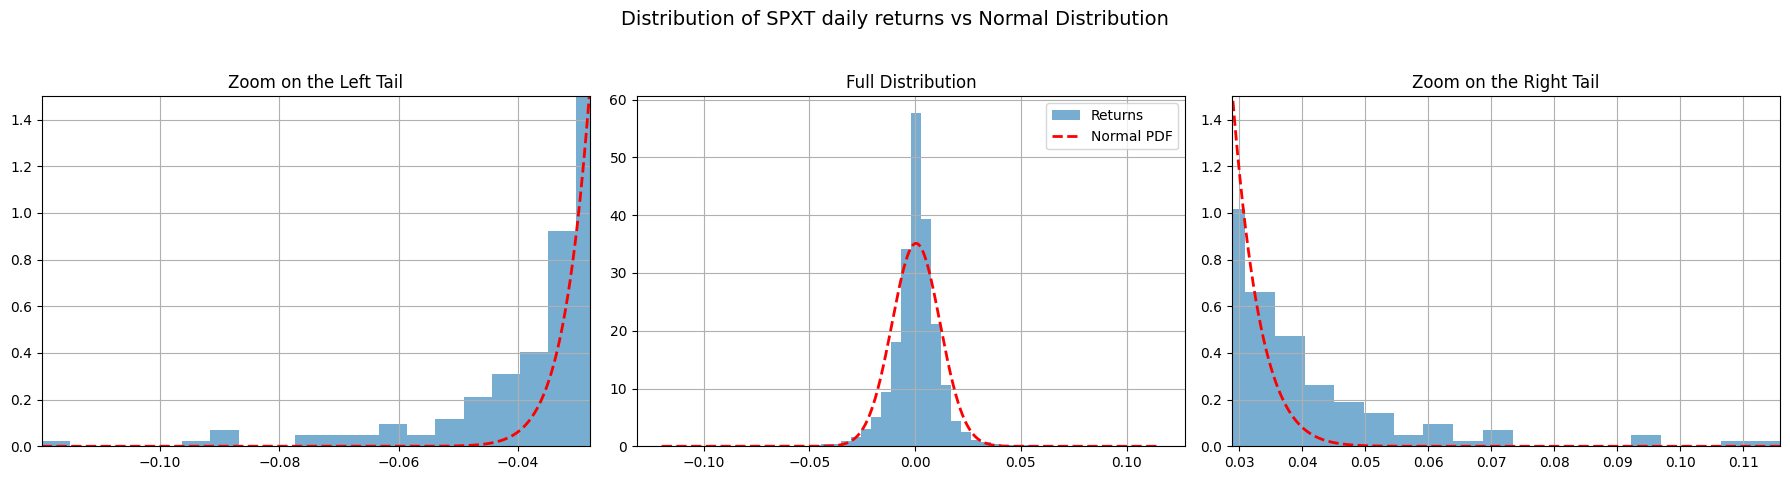

In [5]:
from scipy.stats import norm, skew, kurtosis

# Standardize returns
df_spx['Standardized Return'] = (df_spx['Return'] - sample_mean) / sample_std

# Data
returns = df_spx['Return'].dropna()
standardized = df_spx['Standardized Return'].dropna()

# Stats
ret_skew = skew(returns)
ret_kurt = kurtosis(returns, fisher=False)

norm_data = np.random.normal(loc=sample_mean, scale=sample_std, size=len(returns))
norm_skew = skew(norm_data)
norm_kurt = kurtosis(norm_data, fisher=False)

# Print stats
print(f"Distribution of returns (standardized) - Skewness: {ret_skew:.1f}, Kurtosis: {ret_kurt:.1f}")
print(f"Standard Normal Distribution - Skewness: {norm_skew:.1f}, Kurtosis: {norm_kurt:.1f}")

# Plotting setup
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# X range
x = np.linspace(returns.min(), returns.max(), 1000000)
norm_pdf = norm.pdf(x, loc=sample_mean, scale=sample_std)

# Center plot
axes[1].hist(returns, bins=50, density=True, alpha=0.6, label='Returns')
axes[1].plot(x, norm_pdf, 'r--', linewidth=2, label='Normal PDF')
axes[1].set_title('Full Distribution')
axes[1].legend()
axes[1].grid(True)

# Left tail
axes[0].hist(returns, bins=50, density=True, alpha=0.6)
axes[0].plot(x, norm_pdf, 'r--', linewidth=2)
axes[0].set_xlim(returns.min(), sample_mean - 2.5 * sample_std)
axes[0].set_ylim(0, 1.5)  # Set y-axis limit for left tail
axes[0].set_title('Zoom on the Left Tail')
axes[0].grid(True)

# Right tail
axes[2].hist(returns, bins=50, density=True, alpha=0.6)
axes[2].plot(x, norm_pdf, 'r--', linewidth=2)
axes[2].set_xlim(sample_mean + 2.5 * sample_std, returns.max())
axes[2].set_ylim(0, 1.5)  # Set y-axis limit for right tail
axes[2].set_title('Zoom on the Right Tail')
axes[2].grid(True)

plt.suptitle('Distribution of SPXT daily returns vs Normal Distribution', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




<p style="line-height:2.0">

The high kurtosis (13.4 vs 3.0) reveals that the distribution of returns is **leptokurtic**, with a peaked center and heavy tails.<br>
This suggests that large returns (both positive and negative) **occur more frequently** than would be expected under a normal distribution. <br>Moreover, the **negative skewness** (-0.2 vs 0.0) indicates a longer tail on the left for the distribution of returns, meaning there’s a higher probability of large negative returns. In real-world finance, these represent **market shocks or rare events**, which are underestimated by the normal model.<br><br>

When we compare the empirical distribution of returns with the standard normal distribution, it’s clear they don’t perfectly align — <br> *we’ve reached a fork in the road*.<br><br>

We must now decide: **do we model our returns as if they follow a normal distribution, or do we acknowledge that they may instead follow a fat-tailed distribution?**

<br><br>

**Normal distributions** are convenient.<br><br>
- They come with a well-known formula and only two parameters—mean and variance—that are easy to estimate from data. <br>
- However, this simplicity comes at a cost: we end up underestimating the probability of extreme events, which can be dangerous in risk-sensitive applications like derivative pricing or portfolio management.

<br><br>

**Fat-tailed distributions**, on the other hand, more accurately reflect reality, especially in financial markets where extreme events happen more often than the normal model would predict. But they introduce complexity: <br><br>

- Often, there’s no closed-form expression for the distribution, making it harder to estimate the parameters.<br>

- These distributions may require more than just mean and variance to fully describe.<br>

- Worse still, if the tails are too fat (i.e., the distribution decays very slowly), the variance may not even exist—it becomes infinite. In mathematical terms, the integral that defines variance fails to converge. <br> And if you're a trader pricing a derivative, plugging infinite volatility into your model is hardly going to give you a meaningful result.

<br><br>

**So what should we do?**<br><br>

For now, to keep the mathematics clean and the modeling tractable, **we’ll proceed under the assumption of normally distributed returns**. <br>

Given this assumption, we obtain **our first model** by writing the returns as a random variable drawn from a Normal distribution with a known, constant, non-zero mean and a known, constant, non-zero standard deviation: <br><br>

$\bold{R_{i+1}=\dfrac{S_{i+1}-S_{i}}{S_{i}} = \text{mean} + \text{standard deviation} \times \phi}$. <br><br>

The first term in the rhs is the deterministic part of the model, while the second term represents the randomness. <br>

A collection of $R_{i}$ for $i=0, 1, 2, ... $, is a discrete stochastic process describing the evolution of our random system. <br><br>

To illustrate it, we generate a series of random draws $\phi \sim N(0, 1)$, corresponding to each trading day in our SPXT example.<br>
By implementing our model, we then use these values to simulate returns and we reconstruct a simulated price series from them. <br>
The following chart is a comparison between the realization of the SPXT and the simulated prices. <br>

</p>

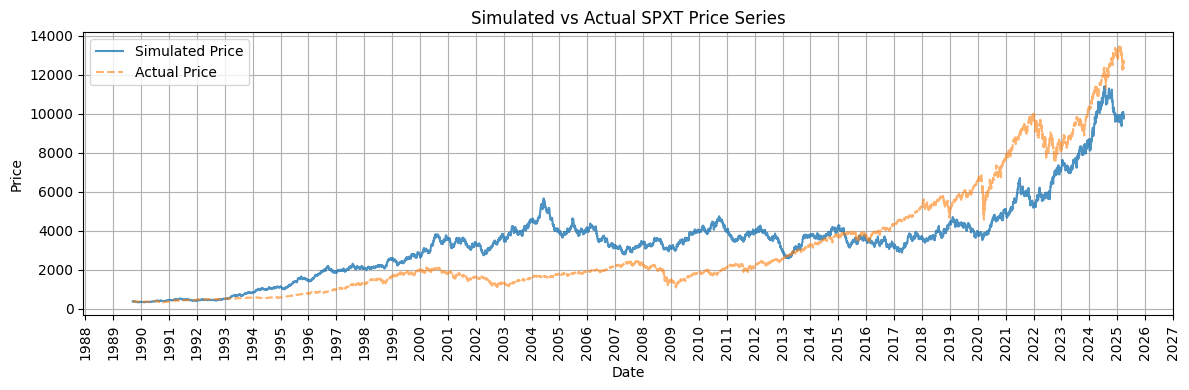

In [19]:

# Generate φ ~ N(0, 1)
np.random.seed(42)  # for reproducibility
phi = np.random.normal(loc=0, scale=1, size=len(df_spx))

# Simulated returns using the model
df_spx['Simulated Return'] = sample_mean + sample_std * phi


# Reconstruct price series from simulated returns
initial_price = df_spx['Price'].iloc[0]
df_spx['Simulated Price'] = initial_price * (1 + df_spx['Simulated Return']).cumprod()

# Plot simulated price
plt.figure(figsize=(12, 4))
plt.plot(df_spx['Date'], df_spx['Simulated Price'], label='Simulated Price', alpha=0.8)
plt.plot(df_spx['Date'], df_spx['Price'], label='Actual Price', alpha=0.6, linestyle='--')

plt.title('Simulated vs Actual SPXT Price Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

# Format date axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

<p style="line-height:2.0">

From the chart, you can see that the actual SPXT series differs from the simulated one. <br>
However, under our assumption of normally distributed returns, the simulation is statistically consistent with the actual market behavior. <br>
They are simply different realizations—different 'parallel universes' of market outcomes. <br>

**So...What happens when we run a lot of simulations and average them?**
</p>

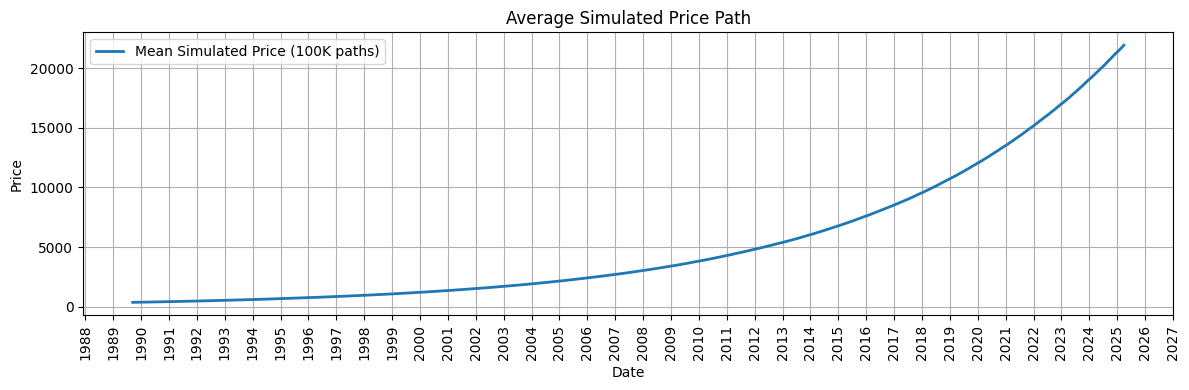

In [20]:

initial_price = df_spx['Price'].iloc[0]
n_days = len(df_spx)
n_simulations = 100_000

# Generate simulations: shape = (n_simulations, n_days)
np.random.seed(42)
phi_matrix = np.random.normal(loc=0, scale=1, size=(n_simulations, n_days))
simulated_returns = sample_mean + sample_std * phi_matrix

# Compute cumulative price paths
simulated_prices = initial_price * np.cumprod(1 + simulated_returns, axis=1)

# Average across simulations at each time step
mean_simulated_price = simulated_prices.mean(axis=0)

# Plot actual vs mean simulated price
plt.figure(figsize=(12, 4))
plt.plot(df_spx['Date'], mean_simulated_price, label='Mean Simulated Price (100K paths)', linewidth=2)
#plt.plot(df_spx['Date'], df_spx['Price'], label='Actual Price', linestyle='--', alpha=0.7)

plt.title('Average Simulated Price Path')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

# Format date axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

<p style="line-height:2.0">

What we see in the chart is a direct consequence of the **law of large numbers**.<br>
When you average a large number of simulations, the **random fluctuations tend to cancel each other out**, revealing the underlying **deterministic behavior** dictated by the model's expected value. <br><br>

*Oh, wait a minute—look at that! The price seems to be growing exponentially! Does it really????* <br><br> 
*Hold on, one thing at a time, cowboy! Let’s take a closer look at the math behind it before we start riding off into the sunset.* <br>

---

### **Timescales**

We now want to take a further step forward by transitioning from a discrete-time stochastic process to a continuous-time one. <br><br>

The key intuition behind using continuous stochastic processes is that, although we typically observe asset prices at discrete intervals (daily, hourly, etc.), in reality, prices can fluctuate continuously - since trading can occur at any moment during market hours.<br>

To model this behavior more accurately, we start from a discrete-time process and **let the time step shrink toward zero**, effectively removing the gap between observations. <br> This limiting process allows us to move from a discrete framework to a continuous one, capturing the dynamic nature of asset prices with greater fidelity. <br><br>

But first we have a question to answer: <br><br>

#### **How do the mean and standard deviation of the returns’ time series scale with the time step between asset price measurements?**<br>

Let's call the time step $\delta t$ and define: <br><br> $\bold{\quad \text{mean} = \mu \delta t^{\alpha}}$ <br><br> for some $\mu$ which we assume to be constant. <br>

To know how the mean scales with the time step we have to find $\alpha$. <br>
If we ignore randomness, our model is simply:<br><br>
$\quad R_{i+1}=\dfrac{S_{i+1}-S_{i}}{S_{i}} = \text{mean} = \mu \delta t^{\alpha} \text{ }$ that can be rewritten as $\text{ }S_{i+1} = S_{i}(1+\mu \delta t^{\alpha})$.<br><br>
If the asset begins at $\text{ }S_{0}\text{ }$ at time $\text{ }t=0\text{ }$ then after one time step we have $\text{ }t=\delta t\text{ }$ and $\text{ }S_{1} = S_{0}(1+\mu \delta t^{\alpha})$.<br><br>
After two time steps we have $\text{ }t=2 \delta t\text{ }$ and $\text{ }S_{2} = S_{1}(1+\mu \delta t^{\alpha}) = S_{0}(1+\mu \delta t^{\alpha})^{2}$.<br>

After $M$ time steps we will have $\text{ }t=M \delta t\text{ }$ and $\text{ }S_{M} = S_{0}(1+\mu \delta t^{\alpha})^{M}$ <br>

By operating a couple of math tricks we can see that $\text{ } S_{0}(1+\mu \delta t^{\alpha})^{M} = S_{0} e^{\displaystyle \log{(1+\mu \delta t^{\alpha})}^{M}}= S_{0} e^{\displaystyle M \log{(1+\mu \delta t^{\alpha})}}$. <br>

Now, time to dust off those Taylor series cobwebs! In particular the *Maclaurin series*. Bear with me: <br>

We know that the Maclaurin series for a function $f(x)$ is $f(x) = f(0) + f'(0)x + \frac{f''(0)}{2!}x^2 + \frac{f^{(3)}(0)}{3!}x^3 + \cdots$ <br><br>

We are interested in $f(x) = \log(1 + x)$ <br>

| Derivative | Expression | Evaluated at $x = 0$ |
|-----------|------------|------------------------|
| $f(x)$ | $ \log(1 + x) $ | $ 0 $ |
| $ f'(x) $ | $ \frac{1}{1 + x} $ | $ 1 $ |
| $ f''(x) $ | $ -\frac{1}{(1 + x)^2} $ | $ -1 $ |
| $ f^{(3)}(x) $ | $ \frac{2}{(1 + x)^3} $ | $ 2 $ |
| $ f^{(4)}(x) $ | $ -\frac{6}{(1 + x)^4} $ | $ -6 $ |
| ... | ... | ... |

$\displaystyle \log(1 + x) = 0 + 1 \cdot x + \dfrac{-1}{2!}x^2 + \dfrac{2}{3!}x^3 + \dfrac{-6}{4!}x^4 + \cdots = x - \dfrac{x^2}{2} + \dfrac{x^3}{3} - \dfrac{x^4}{4} + \cdots$ <br>

This series converges for $\text{ }|x|<1 \text{ }$ and, when $\text{ }|x| \ll 1 \text{ }$, the higher-degree terms become increasingly negligible compared to $\text{ }x$.<br><br>

This allows us to make the following approximation:<br><br>
$\log(1+x) \approx x$ <br><br>
and rewrite our equation as:

$\text{ }S_{M} \approx S_{0} e^{\displaystyle \mu M\delta t^{\alpha}} $<br><br>

but $\text{ } M = \dfrac{t}{\delta t}\text{ }$ and we can write:<br><br>

$\text{ }S(t) \approx S_{0} e^{\displaystyle \mu \dfrac{t}{\delta t}  \delta t^{\alpha}} \approx S_{0} e^{\displaystyle \mu t \delta t^{\alpha-1}}$ <br><br>


Now, we’re faced with three different cases: <br><br>


1. **$\boldsymbol{\alpha > 1}$**:  
   As $\delta t \to 0$, the term $\delta t^{\alpha - 1}$ tends to zero.  
   This means $S(t) \approx S_0$ — essentially a **flat line** for the price over time.  
   Not exactly the most exciting model… doesn’t really make much sense, right?

2. **$\boldsymbol{\alpha < 1}$**:  
   In this case, as $\delta t \to 0$, the exponential blows up to infinity — and so does $S(t)$!  
   In the blink of an eye, we’re all millionaires!  
   …Yeah, let’s stay grounded — reality doesn’t quite work like that.

3. **$\boldsymbol{\alpha = 1}$**:  
   Here, $\delta t^{\alpha - 1} = 1$, and as $\delta t \to 0$ we’re left with a nice, well-behaved expression:  
   
   $\bold{S(t) \approx S_0 e^{\mu t}}$
     
   Much more realistic!

Therefore, the only way to arrive at a model that makes physical and financial sense is by setting **$\text{ }\boldsymbol{\alpha = 1}$**. <br><br>
By doing so, we are saying that **the mean scales linearly with $\bold{\text{ }\delta t}$**, modulated by the factor $\text{ } \mu$. <br>
And wait... this result actually lines up perfectly with what we found earlier: in the absence of randomness, the asset price **grows exponentially** over time. <br><br>
</p>

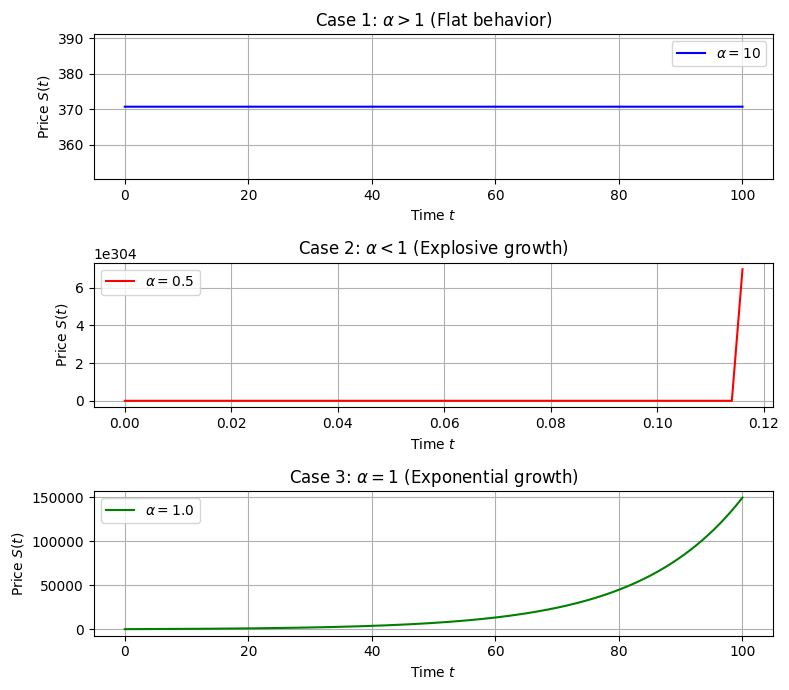

In [21]:

import warnings
warnings.filterwarnings("ignore")

# Parameters
S0 = initial_price         # Initial asset price
mu = 0.06         # Drift coefficient
delta_t = 1e-10   # Small time increment
t = np.linspace(0, 100, 50000)  # Time range from 0 to 1

# Calculate S(t) for three different cases:
# 1. alpha > 1 (e.g., alpha = 1.5) -> nearly flat line
# 2. alpha < 1 (e.g., alpha = 0.5) -> explosive growth
# 3. alpha = 1 (realistic exponential growth)

# Case 1: alpha > 1 (e.g., alpha = 1.5)
alpha1 = 10.0
exponent1 = mu * t * delta_t**(alpha1 - 1)
S_t1 = S0 * np.exp(exponent1)

# Case 2: alpha < 1 (e.g., alpha = 0.5)
alpha2 = 0.5
exponent2 = mu * t * delta_t**(alpha2 - 1)
S_t2 = S0 * np.exp(exponent2)

# Case 3: alpha = 1 (ideal realistic case)
alpha3 = 1.0
exponent3 = mu * t * delta_t**(alpha3 - 1)  # Note: delta_t**(0)=1
S_t3 = S0 * np.exp(exponent3)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 7))

# Plot for Case 1: alpha > 1 (Flat line)
axs[0].plot(t, S_t1, label=r'$\alpha = 10$', color='blue')
axs[0].set_title('Case 1: $\\alpha > 1$ (Flat behavior)')
axs[0].set_xlabel('Time $t$')
axs[0].set_ylabel('Price $S(t)$')
axs[0].legend()
axs[0].grid(True)

# Plot for Case 2: alpha < 1 (Explosive growth)
axs[1].plot(t, S_t2, label=r'$\alpha = 0.5$', color='red')
axs[1].set_title('Case 2: $\\alpha < 1$ (Explosive growth)')
axs[1].set_xlabel('Time $t$')
axs[1].set_ylabel('Price $S(t)$')
axs[1].legend()
axs[1].grid(True)

# Plot for Case 3: alpha = 1 (Realistic exponential growth)
axs[2].plot(t, S_t3, label=r'$\alpha = 1.0$', color='green')
axs[2].set_title('Case 3: $\\alpha = 1$ (Exponential growth)')
axs[2].set_xlabel('Time $t$')
axs[2].set_ylabel('Price $S(t)$')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


<p style="line-height:2.0">

Now that we have a sense of how the mean scales with the time step, let’s bring randomness back into the mix: <br><br>

$\quad\bold{R_{i+1}=\dfrac{S_{i+1}-S_{i}}{S_{i}} = \mu \delta t + \text{standard deviation} \times \phi}$. <br><br>

Just remember: we're treating returns as independent random variables, so we can add their variances, but not their standard deviations. <br> 
For this reason we consider:<br>

$\quad\displaystyle Var = \sigma^{2} \delta t^{2\beta}$<br>

Now, we need to determine the appropriate value for $\beta$. Following the same reasoning we used for the mean, we find that the only choice that makes sense is: <br><br>
$\quad \boldsymbol{ \beta=\dfrac{1}{2}}$<br>

which means that **the standard deviation scales with the square root of the time step** $\text{ } \delta t$.<br>

Putting everything together, we arrive at the refined model: $\displaystyle\quad\bold{R_{i+1}=\dfrac{S_{i+1}-S_{i}}{S_{i}} = \mu \delta t + \sigma\phi\delta t^{\frac{1}{2}}}$. <br>

Again, the model reflects that over short periods, returns are mostly dominated by randomness (the noise), but as time accumulates, the deterministic trend starts to emerge more clearly.

---

### **From discrete-time to continuous-time: the Wiener process**

However, we haven't yet reached our main goal: transitioning to a **continuous model**. <br> 
To do this, we need to make a few adjustments: <br><br>

- We transform $R_{i+1}$ into $\dfrac{dS}{S}$, where $dS$ represents an infinitesimal price change over the interval $[t, t + dt]$, with $dt$ being an arbitrarily small time increment.<br><br>
- We replace $\mu \delta t $ with $ \mu dt $. <br><br>
- But how do we handle the term $ \sigma \cdot \phi \cdot \delta t^{\frac{1}{2}} $? <br><br>

As we transition to continuous-time models, it's essential to find a counterpart to the discrete random variable $\phi$ that maintains the properties of randomness and normality in an infinitesimal time framework. This is where the **Wiener process** (also known as Brownian motion) becomes indispensable.

Why?

Because the Wiener process {$W_{t}$}$_{t\geq0+}$ has the following properties:

0. $W_{0}=0$

1.  **Continuous Paths**: The process $W_{t}$ is continuous in $t$ with probability 1.

2. **Independent Increments**: Changes $ dW_{t} = W_{t+dt} - W_{t} $ over non-overlapping intervals are independent.

3. **Normally Distributed Increments**: For small $dt$, the increment $dW_{t} \sim \mathcal{N}(0, dt)$. This means the variance scales linearly with time.

Thanks to these properties,  we can say that the stochastic term $ \sigma \phi \delta t^{\frac{1}{2}}$, that in the discrete model represents a random fluctuation, behaves like $ \sigma dW_{t} $ as $ \delta t \to 0 $.

This makes the Wiener process the **natural continuous-time analogue** of the discrete standard normal variable $ \phi $.

---

### **The GBM**

Our asset price model in the continuous-time limit, using the Wiener process notation, can finally be written as: <br><br>
#### $\quad dS = \mu S_t dt + \sigma S_t dW_{t} $ <br><br>

This equation tells us that:

- The **drift term** $\mu S_t dt$ captures the expected return over time.
- The **stochastic term** $ \sigma S_t dW_t $ captures random shocks to the asset price via Brownian motion.

The name **Geometric Brownian Motion (GBM)** reflects two key aspects of the process:<br>

1. "Brownian Motion": randomness in the model is driven by a **Wiener process** (easy one)<br><br>
2. "Geometric": indicates that the process evolves **multiplicatively**, meaning the change in price is proportional to its current price value. This leads to **exponential growth or decay**.

The GBM is our first encounter with a **Stochastic Differential Equation (SDE)**: <br>
To fully appreciate what's going on under the hood, we might need to refresh some elementary stochastic calculus. <br><br>
If you bear with me, you’ll see... we’re far from done with this.

</p>

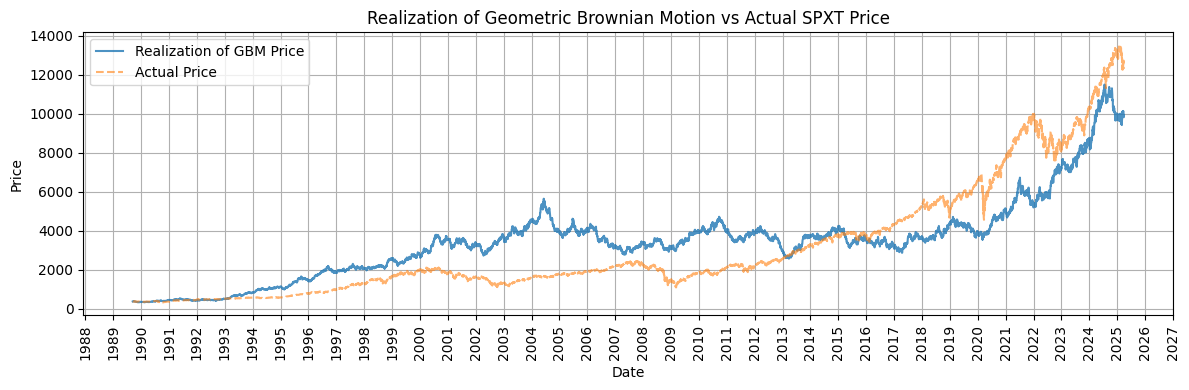

In [22]:

dt = 1 / 252  # ~252 trading days in a year

# Calculate log returns
log_returns = np.log(df_spx['Price'] / df_spx['Price'].shift(1)).dropna()

# Estimate parameters
N = len(log_returns)
dt = 1/252  # Daily data (assuming 252 trading days/year)
r_log_mean = np.mean(log_returns)

sigma = np.std(log_returns) * np.sqrt(252)

mu = (r_log_mean / dt) + (sigma ** 2) / 2

np.random.seed(42)
phi = np.random.normal(0, 1, size=N)
dW = phi * np.sqrt(dt)
W = np.insert(np.cumsum(dW), 0, 0)  # start W_0 = 0

# Generate GBM price path
S0 = df_spx['Price'].iloc[0]
t = np.linspace(0, N * dt, N + 1)
S_t = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

# (mu - 0.5 * sigma**2) = r_log_mean/dt 

# Add to DataFrame
df_spx['Simulated GBM Price'] = S_t

# Plot actual vs GBM-simulated price
plt.figure(figsize=(12, 4))
plt.plot(df_spx['Date'], df_spx['Simulated GBM Price'], label='Realization of GBM Price', alpha=0.8)
plt.plot(df_spx['Date'], df_spx['Price'], label='Actual Price', alpha=0.6, linestyle='--')

plt.title('Realization of Geometric Brownian Motion vs Actual SPXT Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

# Format date axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=90)

plt.legend()
plt.tight_layout()
plt.show()
